<a href="https://colab.research.google.com/github/zach-gousseau/syde675-project/blob/main/models/675_spatial_Nishad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
pip install rasterio

In [104]:
# pip install netCDF4

In [105]:
# pip install zarr

In [106]:
pip install rioxarray

In [107]:
!pip install xarray[complete]

In [108]:
import sys
sys.path.append('/content/drive/MyDrive/SYDE 675/Project/Models')

In [109]:
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from xgrid_utils import calc_spatial_integral

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import rioxarray
from rasterio import rio

from sklearn.preprocessing import StandardScaler

# Load data

In [110]:
data_path = '/content/drive/MyDrive/SYDE 675/Project/Data/'
file_path = 'era5_monthly.zarr'

In [111]:
ds = xr.open_dataset(data_path + file_path, engine='zarr').isel(time=slice(0, 50)) #.sel(latitude=slice(89, None), longitude=slice(-20, 20))

In [112]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 1440, time: 50)
Coordinates:
  * latitude   (latitude) float32 65.0 65.25 65.5 65.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28
Data variables: (12/19)
    d2m        (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    fg10       (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    mwd        (time, latitude, longitude) float32 ...
    mwp        (time, latitude, longitude) float32 ...
    ...         ...
    swh        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...

u10
v10
d2m
t2m
tp
sf
sst
siconc
ssrd
sshf
slhf
msl

## Variable names and definitions

* u10 = 10m u-component of wind,	m s-1	
>Eastward component of the 10m wind. It is the horizontal speed of air moving towards the east, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the V component of 10m wind to give the speed and direction of the horizontal 10m wind.

* v10 = 10m v-component of wind,	m s-1
>	Northward component of the 10m wind. It is the horizontal speed of air moving towards the north, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the U component of 10m wind to give the speed and direction of the horizontal 10m wind.

* d2m = 2m dewpoint temperature, K
> Temperature to which the air, at 2 metres above the surface of the Earth, would have to be cooled for saturation to occur. It is a measure of the humidity of the air. Combined with temperature and pressure, it can be used to calculate the relative humidity. 2m dew point temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. Temperature measured in kelvin can be converted to degrees Celsius (°C) by subtracting 273.15.

* t2m	= 2m temperature,	K	
>Temperature of air at 2m above the surface of land, sea or in-land waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. Temperature measured in kelvin can be converted to degrees Celsius (°C) by subtracting 273.15.

* tp = Total precipitation,	m	
> Accumulated liquid and frozen water, including rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation (that precipitation which is generated by large-scale weather patterns, such as troughs and cold fronts) and convective precipitation (generated by convection which occurs when air at lower levels in the atmosphere is warmer and less dense than the air above, so it rises). Precipitation variables do not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.

* sf = Snowfall, m of water equivalent	
>Accumulated total snow that has fallen to the Earth's surface. It consists of snow due to the large-scale atmospheric flow (horizontal scales greater than around a few hundred metres) and convection where smaller scale areas (around 5km to a few hundred kilometres) of warm air rise. If snow has melted during the period over which this variable was accumulated, then it will be higher than the snow depth. This variable is the total amount of water accumulated from the beginning of the forecast time to the end of the forecast step. The units given measure the depth the water would have if the snow melted and was spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.

* sst = Sea surface temperature, Units	K
>This parameter is the temperature of sea water near the surface.
This parameter is taken from various providers, who process the observational data in different ways. Each provider uses data from several different observational sources. For example, satellites measure sea surface temperature (SST) in a layer a few microns thick in the uppermost mm of the ocean, drifting buoys measure SST at a depth of about 0.2-1.5m, whereas ships sample sea water down to about 10m, while the vessel is underway. Deeper measurements are not affected by changes that occur during a day, due to the rising and setting of the Sun (diurnal variations).
Sometimes this parameter is taken from a forecast made by coupling the NEMO ocean model to the ECMWF Integrated Forecasting System. In this case, the SST is the average temperature of the uppermost metre of the ocean and does exhibit diurnal variations.

* siconc = Sea ice area fraction, Fraction

* ssrd =	Surface solar radiation downwards, Units	J m-2
>This parameter is the amount of solar radiation (also known as shortwave radiation) that reaches a horizontal plane at the surface of the Earth. This parameter comprises both direct and diffuse solar radiation. 
>Radiation from the Sun (solar, or shortwave, radiation) is partly reflected back to space by clouds and particles in the atmosphere (aerosols) and some of it is absorbed. The rest is incident on the Earth's surface (represented by this parameter). See further documentation. 
>To a reasonably good approximation, this parameter is the model equivalent of what would be measured by a pyranometer (an instrument used for measuring solar radiation) at the surface. However, care should be taken when comparing model parameters with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box. 

* sshf = Surface sensible heat flux, Units	J m-2
>This parameter is the transfer of heat between the Earth's surface and the atmosphere through the effects of turbulent air motion (but excluding any heat transfer resulting from condensation or evaporation).
The magnitude of the sensible heat flux is governed by the difference in temperature between the surface and the overlying atmosphere, wind speed and the surface roughness. For example, cold air overlying a warm surface would produce a sensible heat flux from the land (or ocean) into the atmosphere. See further documentation 

* slhf = Surface latent heat flux, Units	J m-2
>This parameter is the transfer of latent heat (resulting from water phase changes, such as evaporation or condensation) between the Earth's surface and the atmosphere through the effects of turbulent air motion. Evaporation from the Earth's surface represents a transfer of energy from the surface to the atmosphere. See further documentation
>This parameter is accumulated over a particular time period which depends on the data extracted.The units are joules per square metre (J m-2). To convert to watts per square metre (W m-2), the accumulated values should be divided by the accumulation period expressed in seconds.
>The ECMWF convention for vertical fluxes is positive downwards.

* msl = Mean sea level pressure, Units	Pa
>This parameter is the pressure (force per unit area) of the atmosphere adjusted to the height of mean sea level.
It is a measure of the weight that all the air in a column vertically above the area of Earth's surface would have at that point, if the point were located at the mean sea level. It is calculated over all surfaces - land, sea and in-land water.
Maps of mean sea level pressure are used to identify the locations of low and high pressure systems, often referred to as cyclones and anticyclones. Contours of mean sea level pressure also indicate the strength of the wind. Tightly packed contours show stronger winds.
The units of this parameter are pascals (Pa). Mean sea level pressure is often measured in hPa and sometimes is presented in the old units of millibars, mb (1 hPa = 1 mb = 100 Pa).




Other variables - 
* e =	Evaporation,	m of water equivalent
> Accumulated amount of water that has evaporated from the Earth's surface, including a simplified representation of transpiration (from vegetation), into vapour in the air above. This variable is accumulated from the beginning of the forecast to the end of the forecast step. The ECMWF Integrated Forecasting System convention is that downward fluxes are positive. Therefore, negative values indicate evaporation and positive values indicate condensation.

* smlt = Snowmelt, m of water equivalent
> This parameter is the accumulated amount of water that has melted from snow in the snow-covered area of a grid box.
>The ECMWF Integrated Forecast System represents snow as a single additional layer over the uppermost soil level. The snow may cover all or part of the grid box. This parameter is the depth of water there would be if the melted snow (from the snow-covered area of a grid box ) were spread evenly over the whole grid box. For example, if half the grid box were covered in snow with a water equivalent depth of 0.02m, this parameter would have a value of 0.01m.

In [113]:
# variables = ['u10', 'v10', 'd2m', 't2m', 'tp', 'sf', 'sst', 'siconc', 'ssrd', 'sshf', 'slhf', 'msl']
variables = ['u10', 'v10', 'd2m', 't2m', 'siconc']
ds_short = ds[variables]

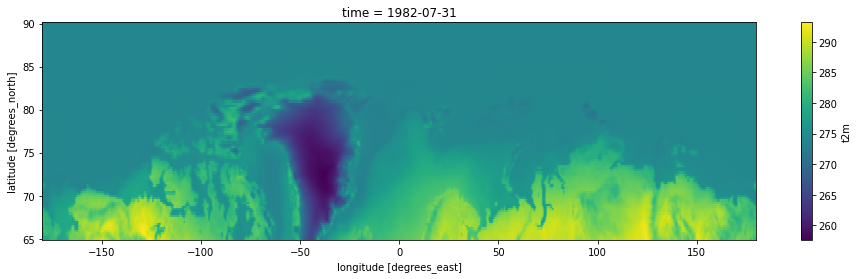

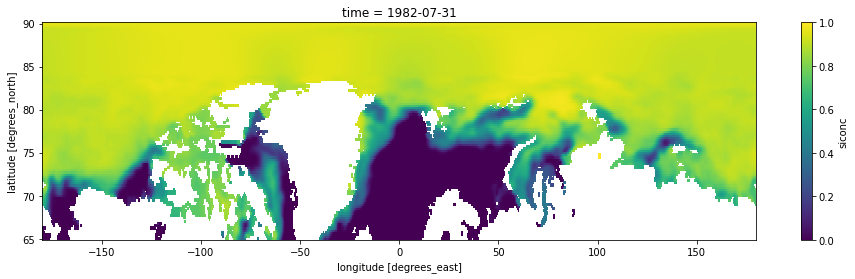

In [114]:
ds_short.isel(time=-8).t2m.plot(figsize=(16, 4))
ds_short.isel(time=-8).siconc.plot(figsize=(16, 4))

In [115]:
ds_short.keys()

KeysView(<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 1440, time: 50)
Coordinates:
  * latitude   (latitude) float32 65.0 65.25 65.5 65.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...)

In [116]:
ds_short.info()

xarray.Dataset {
dimensions:
	latitude = 101 ;
	longitude = 1440 ;
	time = 50 ;

variables:
	float32 u10(time, latitude, longitude) ;
	float32 v10(time, latitude, longitude) ;
	float32 d2m(time, latitude, longitude) ;
	float32 t2m(time, latitude, longitude) ;
	float32 siconc(time, latitude, longitude) ;
	float32 latitude(latitude) ;
		latitude:long_name = latitude ;
		latitude:units = degrees_north ;
	float32 longitude(longitude) ;
		longitude:long_name = longitude ;
		longitude:units = degrees_east ;
	datetime64[ns] time(time) ;

// global attributes:
}

## Change to polar coordinates

In [117]:
ds_polar = ds_short.rio.write_crs(4326).rio.reproject(3995)

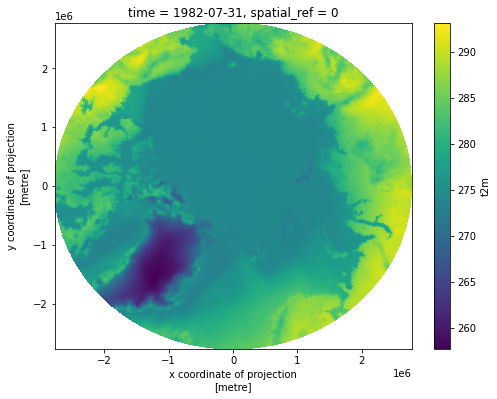

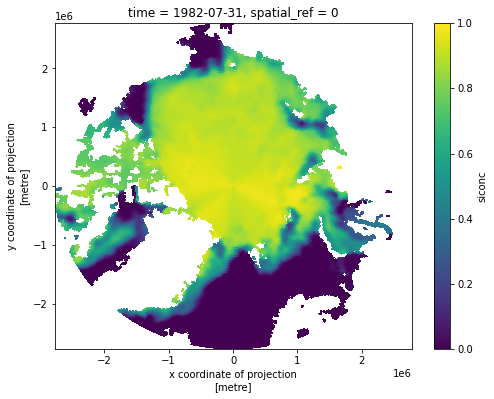

In [118]:
ds_polar.isel(time=-8).t2m.plot(figsize=(8, 6))
ds_polar.isel(time=-8).siconc.plot(figsize=(8, 6))

In [119]:
ds_polar

<xarray.Dataset>
Dimensions:      (time: 50, x: 1021, y: 1021)
Coordinates:
  * x            (x) float64 -2.77e+06 -2.765e+06 ... 2.766e+06 2.771e+06
  * y            (y) float64 2.77e+06 2.765e+06 ... -2.766e+06 -2.771e+06
  * time         (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28
    spatial_ref  int64 0
Data variables:
    u10          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    v10          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    d2m          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    t2m          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    siconc       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [120]:
ds_short

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 1440, time: 50)
Coordinates:
  * latitude   (latitude) float32 65.0 65.25 65.5 65.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...

In [121]:
extents

<xarray.DataArray 'siconc' (time: 50)>
array([ 0.87813339,  1.01224475,  0.98807884,  0.93686762,  0.76295389,
        0.44713778, -0.40852734, -1.68860821, -2.39505557, -0.91059404,
       -0.13289765,  0.31202903,  0.58804124,  0.75021447,  0.74040658,
        0.67001929,  0.50635694,  0.19533346, -0.41818892, -1.60294115,
       -1.87827595, -0.960107  ,  0.20557938,  0.61063689,  0.74847612,
        0.67325205,  0.79119269,  0.83897966,  0.81500273,  0.47508597,
       -0.38782273, -1.72769419, -2.35438585, -1.08132549,  0.00515792,
        0.63377604,  0.89985456,  0.94044859,  0.87485895,  0.88863348,
        0.64001324,  0.37621585, -0.39337786, -1.59665644, -2.21552714,
       -0.63777089,  0.11629068,  0.40554196,  0.44617987,  0.61676251])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28

In [122]:
# weights = np.cos(np.deg2rad(ds.latitude))
# extents = (ds.siconc > 0.15).weighted(weights).sum(dim=['latitude', 'longitude'])

extents = calc_spatial_integral(ds_short.siconc > 0.15) / 1000**2  # SIE in km2
extents = (extents - extents.mean())/extents.std()

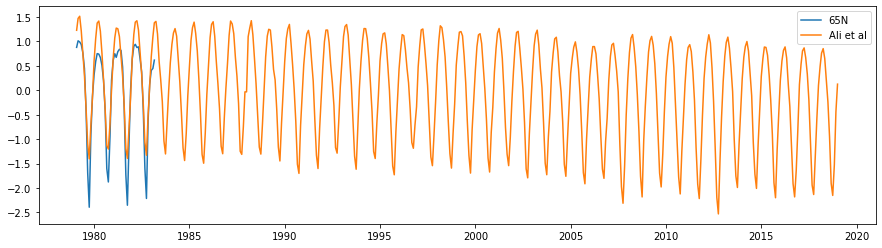

In [123]:
# Compare Ali's extents to ours (Ali = 25N)

path = '/content/drive/MyDrive/SYDE 675/Project/Data'
target_path = path + '/monthly_target.npy'

extents_ali = np.load(target_path, allow_pickle=True)
extents_ali = (extents_ali - extents_ali.mean())/extents_ali.std()
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')

plt.figure(figsize=(15, 4))
plt.plot(ds_polar.time, extents, label='65N')
plt.plot(month_range, extents_ali, label='Ali et al')
plt.legend()

In [124]:
ds_polar = ds_polar.coarsen({'x':4, 'y':4}, boundary='trim').mean()

In [125]:
# Fill nans with 0
ds_polar = ds_polar.fillna(0)

In [126]:
pip install sklearn-xarray

In [127]:
ds_polar

<xarray.Dataset>
Dimensions:      (time: 50, x: 255, y: 255)
Coordinates:
  * x            (x) float64 -2.762e+06 -2.74e+06 ... 2.736e+06 2.758e+06
  * y            (y) float64 2.762e+06 2.74e+06 ... -2.736e+06 -2.758e+06
  * time         (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28
    spatial_ref  int64 0
Data variables:
    u10          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    v10          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    d2m          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    t2m          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    siconc       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [128]:
ds_polar_std = (ds_polar - ds_polar.mean())/ds_polar.std()

In [129]:
ds_polar_std

<xarray.Dataset>
Dimensions:      (time: 50, x: 255, y: 255)
Coordinates:
  * x            (x) float64 -2.762e+06 -2.74e+06 ... 2.736e+06 2.758e+06
  * y            (y) float64 2.762e+06 2.74e+06 ... -2.736e+06 -2.758e+06
  * time         (time) datetime64[ns] 1979-01-31 1979-02-28 ... 1983-02-28
    spatial_ref  int64 0
Data variables:
    u10          (time, y, x) float64 0.0926 0.0926 0.0926 ... 0.0926 0.0926
    v10          (time, y, x) float64 0.1042 0.1042 0.1042 ... 0.1042 0.1042
    d2m          (time, y, x) float64 -1.951 -1.951 -1.951 ... -1.951 -1.951
    t2m          (time, y, x) float64 -1.943 -1.943 -1.943 ... -1.943 -1.943
    siconc       (time, y, x) float64 -0.7405 -0.7405 ... -0.7405 -0.7405

In [130]:
# from sklearn_xarray import wrap
# Xt = wrap(StandardScaler()).fit_transform(ds_polar)

In [131]:
# # standardize data
# scaler = StandardScaler()
# train_array = scaler.fit_transform(train_array.reshape(-1, np.prod(train_array.shape[1:])).T).T.reshape(train_array.shape)
# test_array = scaler.transform(test_array.reshape(-1, np.prod(test_array.shape[1:])).T).T.reshape(test_array.shape)

In [132]:
# Add timesteps to gridded and extent data
num_timesteps = 3

def create_timesteps(arr, num_timesteps=3):
    timesteps = [arr[:-(num_timesteps - 1)]]
    
    for i in range(1, num_timesteps - 1):
        timesteps.append(arr[i:-((num_timesteps-1)-i)])
                 
    timesteps.append(arr[(num_timesteps - 1):])
    return np.array(timesteps)

# Gridded
ds_timesteps = ds_polar_std.rolling(time=num_timesteps).construct('timesteps')
# X_grid = np.array([ds_timesteps[var_] for var_ in ds_timesteps])
X_grid = np.array(ds_timesteps.to_array())
# X_grid = np.nan_to_num(X_grid)
# print(X_grid.shape)
X_grid = X_grid.transpose((1, 4, 2, 3, 0))[num_timesteps - 1: -1]
print(X_grid.shape)

# Extent
X_extent = create_timesteps(extents, num_timesteps).T[:-1]  # extents[num_timesteps: -1]  # create_timesteps(extents, num_timesteps).T
y_extent = np.expand_dims(extents[num_timesteps:], -1)

(47, 3, 255, 255, 5)


In [133]:
def split_time(ds, test_size):
    idx = int(len(ds.time) * (1 - test_size))
    train, test = ds.isel(time=slice(None, idx)), ds.isel(time=slice(idx, None))
    return train, test

In [134]:
print(X_grid.shape)  # samples, timesteps,  x, y, variables
print(X_extent.shape)  # samples, timesteps
print(y_extent.shape)  # samples, timesteps

(47, 3, 255, 255, 5)
(47, 3)
(47, 1)


In [135]:
test_size = 0.2

split_index = int(len(y_extent) * (1 - test_size))

X_grid_train = X_grid[:split_index]
X_extent_train = X_extent[:split_index]
y_extent_train = y_extent[:split_index]

X_grid_test = X_grid[split_index + (num_timesteps - 1):]
X_extent_test = X_extent[split_index + (num_timesteps - 1):]
y_extent_test = y_extent[split_index + (num_timesteps - 1):]

In [136]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(num_timesteps, *X_grid.shape[2:]))
extent_inp = layers.Input(shape=(num_timesteps, 1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="valid",
    return_sequences=True,
    activation="relu",
    # dropout=0.2,
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(3, 3),
    padding="valid",
    return_sequences=True,
    activation="relu",
    # dropout=0.2,
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="valid",
    return_sequences=False,
    activation="relu",
    # dropout=0.2,
)(x)

x = layers.MaxPooling2D(pool_size=(2, 2), padding='valid', data_format='channels_last')(x)

x = layers.Conv2D(
    filters=1, kernel_size=(3, 3), activation="relu", padding="valid", data_format='channels_last',
)(x)

# print(x.shape)
shape = [tf.shape(x)[k] for k in range(4)]
x = tf.reshape(x, [shape[0], shape[1]*shape[2]*shape[3]])  # Flattens
print(x.shape)

# LSTMify the input extents
x_extent = layers.LSTM(64, return_sequences=True)(extent_inp)
x_extent = layers.LSTM(32, return_sequences=True)(x_extent)
x_extent = layers.LSTM(1, return_sequences=False)(x_extent)

x = layers.Concatenate(axis=-1)([x, x_extent])
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model([inp, extent_inp], x)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

(None, 14884)
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 3, 255, 255  0           []                               
                                , 5)]                                                             
                                                                                                  
 conv_lstm2d_49 (ConvLSTM2D)    (None, 3, 253, 253,  42752       ['input_35[0][0]']               
                                 32)                                                              
                                                                                                  
 batch_normalization_32 (BatchN  (None, 3, 253, 253,  128        ['conv_lstm2d_49[0][0]']         
 ormalization)                   32)                                         

In [147]:
def get_batches(X, y, batch_size=10):
    n_samples = y.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    # np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start: end]
        
        # If multiple X inputs, yield as yield
        if isinstance(X, list):
            yield [x[batch_idx] for x in X], y[batch_idx]
        else:
            yield X[batch_idx], y[batch_idx]

# Callbacks
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Hyperparameters
epochs = 10
batch_size = 10
# Fit 
history = model.fit([X_grid_train, X_extent_train], y_extent_train, batch_size=batch_size,
    epochs=epochs,
    # validation_data=get_batches([X_grid_test, X_extent_test], y_extent_test, batch_size=batch_size),
    validation_data = [[X_grid_test, X_extent_test], y_extent_test],
    # callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
4/4 [==============================] - 14s 4s/step - loss: 0.0756 - val_loss: 1.0845
Epoch 2/10
4/4 [==============================] - 11s 3s/step - loss: 0.0643 - val_loss: 1.0837
Epoch 3/10
4/4 [==============================] - 11s 3s/step - loss: 0.0615 - val_loss: 1.0837
Epoch 4/10
4/4 [==============================] - 12s 3s/step - loss: 0.0367 - val_loss: 1.0834
Epoch 5/10
4/4 [==============================] - 12s 3s/step - loss: 0.0313 - val_loss: 1.0837
Epoch 6/10
4/4 [==============================] - 12s 3s/step - loss: 0.0244 - val_loss: 1.0837
Epoch 7/10
4/4 [==============================] - 12s 3s/step - loss: 0.0302 - val_loss: 1.0837
Epoch 8/10
4/4 [==============================] - 12s 3s/step - loss: 0.0205 - val_loss: 1.0839
Epoch 9/10
4/4 [==============================] - 12s 3s/step - loss: 0.0116 - val_loss: 1.0836
Epoch 10/10
4/4 [==============================] - 11s 3s/step - loss: 0.0142 - val_loss: 1.0836


In [140]:
y_pred = model.predict([X_grid_test, X_extent_test])

In [141]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_extent_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.041


In [144]:
y_pred


array([[-0.01564949],
       [-0.01585174],
       [-0.0161659 ],
       [-0.0164349 ],
       [-0.01654132],
       [-0.01639965],
       [-0.01609707],
       [-0.01587505]], dtype=float32)

In [146]:
y_extent_test

array([[-0.39337786],
       [-1.59665644],
       [-2.21552714],
       [-0.63777089],
       [ 0.11629068],
       [ 0.40554196],
       [ 0.44617987],
       [ 0.61676251]])

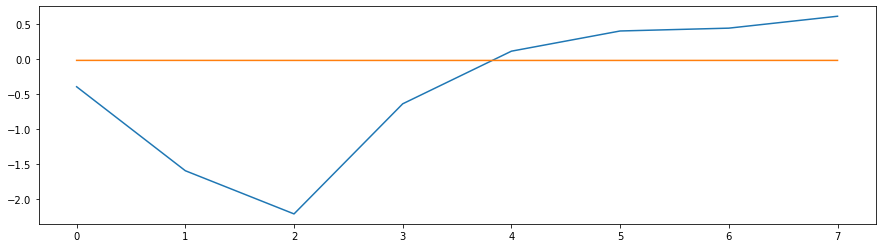

In [143]:
plt.figure(figsize=(15, 4))
plt.plot(y_extent_test, label='65N')
plt.plot(y_pred, label='pred')